In [2]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 944.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 10.7 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.5-cp310-cp310-linux_x86_64.whl size=727809 sha256=0c75ca7e1ce60ddc36b7c82ed717515130843ab50e76d6e1690b773fa922bd97
  Stored in directory: /root/.cache/pip/wheels/06/80/9b/98db0d58349a2f5c09f8406789ade4270762f97b7d26f2fa22
Successfully built peewee


# MA crossing and RSI Comparison

[*********************100%%**********************]  1 of 1 completed


Moving Average Crossover Strategy Return: 9.05%
RSI Strategy Return: 6.67%


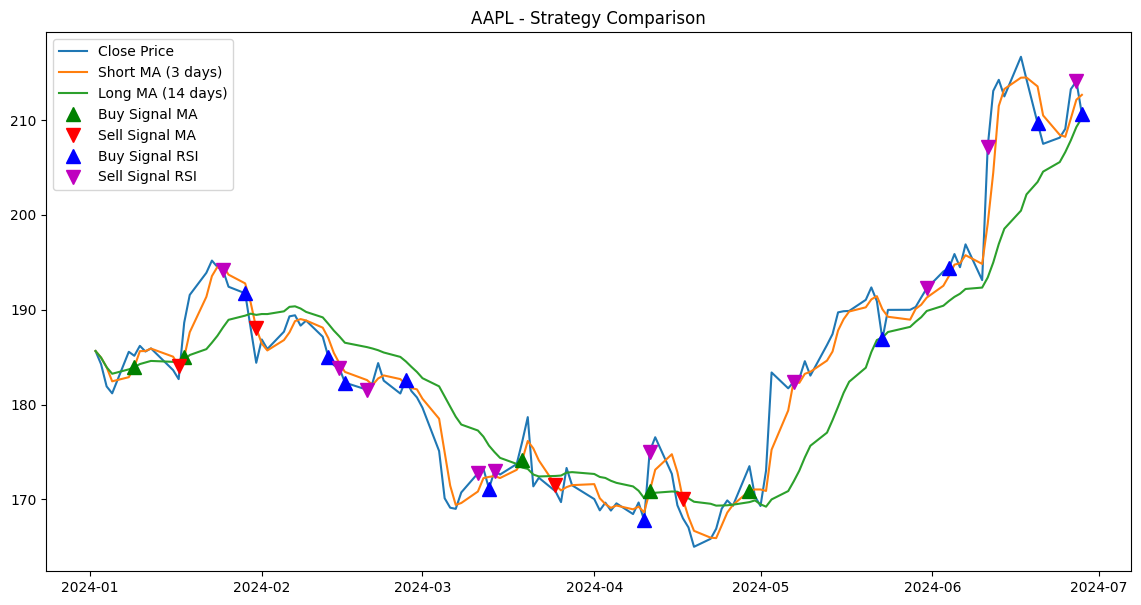

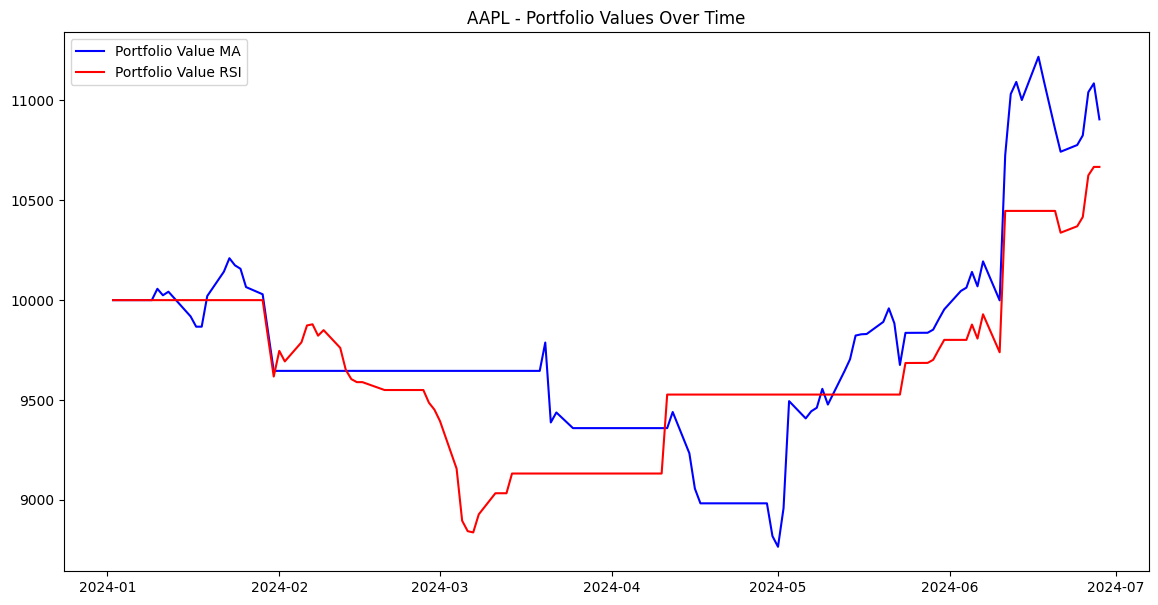

In [53]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Load test data
symbol = 'AAPL'
start_date_test = "2024-01-01"
end_date_test = "2024-06-30"
data_test = yf.download(symbol, start=start_date_test, end=end_date_test)

# Moving Average Crossover Strategy
def moving_average_crossover(data, short_window, long_window):
    data['Short_MA'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
    data['Long_MA'] = data['Close'].rolling(window=long_window, min_periods=1).mean()
    data['Signal_MA'] = 0.0
    data['Signal_MA'][short_window:] = np.where(data['Short_MA'][short_window:] > data['Long_MA'][short_window:], 1.0, 0.0)
    data['Position_MA'] = data['Signal_MA'].diff()
    return data

# RSI Strategy
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def rsi_strategy(data, rsi_period, overbought, oversold):
    data['RSI'] = calculate_rsi(data, rsi_period)
    data['Signal_RSI'] = 0.0
    data['Signal_RSI'][rsi_period:] = np.where(data['RSI'][rsi_period:] < oversold, 1.0, 0.0)
    data['Signal_RSI'][rsi_period:] = np.where(data['RSI'][rsi_period:] > overbought, -1.0, data['Signal_RSI'][rsi_period:])
    data['Position_RSI'] = data['Signal_RSI'].diff()
    return data

# Apply strategies
data_test = moving_average_crossover(data_test, short_window=3, long_window=14)
data_test = rsi_strategy(data_test, rsi_period=14, overbought=70, oversold=30)

# Calculate returns and portfolio value for Moving Average Crossover
initial_cash = 10000
cash_ma = initial_cash
position_ma = 0
data_test['Portfolio_MA'] = np.nan

for i in range(len(data_test)):
    if data_test['Position_MA'].iloc[i] == 1.0:  # Buy signal
        if cash_ma > 0:  # Ensure we only buy if we have cash
            position_ma = cash_ma / data_test['Close'].iloc[i]
            cash_ma = 0
    elif data_test['Position_MA'].iloc[i] == -1.0:  # Sell signal
        if position_ma > 0:  # Ensure we only sell if we have a position
            cash_ma = position_ma * data_test['Close'].iloc[i]
            position_ma = 0
    data_test['Portfolio_MA'].iloc[i] = cash_ma + position_ma * data_test['Close'].iloc[i]

final_value_MA = cash_ma + position_ma * data_test['Close'].iloc[-1]
return_MA = (final_value_MA - initial_cash) / initial_cash * 100

# Calculate returns and portfolio value for RSI Strategy
cash_rsi = initial_cash
position_rsi = 0
data_test['Portfolio_RSI'] = np.nan

for i in range(len(data_test)):
    if data_test['Position_RSI'].iloc[i] == 1.0:  # Buy signal
        if cash_rsi > 0:  # Ensure we only buy if we have cash
            position_rsi = cash_rsi / data_test['Close'].iloc[i]
            cash_rsi = 0
    elif data_test['Position_RSI'].iloc[i] == -1.0:  # Sell signal
        if position_rsi > 0:  # Ensure we only sell if we have a position
            cash_rsi = position_rsi * data_test['Close'].iloc[i]
            position_rsi = 0
    data_test['Portfolio_RSI'].iloc[i] = cash_rsi + position_rsi * data_test['Close'].iloc[i]

final_value_RSI = cash_rsi + position_rsi * data_test['Close'].iloc[-1]
return_RSI = (final_value_RSI - initial_cash) / initial_cash * 100

# Print the results
print(f"Moving Average Crossover Strategy Return: {return_MA:.2f}%")
print(f"RSI Strategy Return: {return_RSI:.2f}%")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data_test['Close'], label='Close Price')
plt.plot(data_test['Short_MA'], label='Short MA (3 days)')
plt.plot(data_test['Long_MA'], label='Long MA (14 days)')
plt.plot(data_test[data_test['Position_MA'] == 1.0].index, data_test['Short_MA'][data_test['Position_MA'] == 1.0], '^', markersize=10, color='g', lw=0, label='Buy Signal MA')
plt.plot(data_test[data_test['Position_MA'] == -1.0].index, data_test['Short_MA'][data_test['Position_MA'] == -1.0], 'v', markersize=10, color='r', lw=0, label='Sell Signal MA')
plt.plot(data_test[data_test['Position_RSI'] == 1.0].index, data_test['Close'][data_test['Position_RSI'] == 1.0], '^', markersize=10, color='b', lw=0, label='Buy Signal RSI')
plt.plot(data_test[data_test['Position_RSI'] == -1.0].index, data_test['Close'][data_test['Position_RSI'] == -1.0], 'v', markersize=10, color='m', lw=0, label='Sell Signal RSI')
plt.title(f'{symbol} - Strategy Comparison')
plt.legend()

# Plot portfolio values
plt.figure(figsize=(14, 7))
plt.plot(data_test.index, data_test['Portfolio_MA'], label='Portfolio Value MA', color='blue')
plt.plot(data_test.index, data_test['Portfolio_RSI'], label='Portfolio Value RSI', color='red')
plt.title(f'{symbol} - Portfolio Values Over Time')
plt.legend()
plt.show()


To backtest these two algorithms across all 500 members of the S&P 500, we need to:

Retrieve the list of S&P 500 companies.
Download historical stock data for each company.
Apply both trading strategies to each stock.
Calculate and store the returns for each strategy.
Compute the average returns for both strategies across all stocks.

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import time

# Get list of S&P 500 companies
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_table = pd.read_html(sp500_url, header=0)
sp500_symbols = sp500_table[0]['Symbol'].tolist()

# Moving Average Crossover Strategy
def moving_average_crossover(data, short_window, long_window):
    data['Short_MA'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
    data['Long_MA'] = data['Close'].rolling(window=long_window, min_periods=1).mean()
    data['Signal_MA'] = 0.0
    data['Signal_MA'][short_window:] = np.where(data['Short_MA'][short_window:] > data['Long_MA'][short_window:], 1.0, 0.0)
    data['Position_MA'] = data['Signal_MA'].diff()
    return data

# RSI Strategy
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def rsi_strategy(data, rsi_period, overbought, oversold):
    data['RSI'] = calculate_rsi(data, rsi_period)
    data['Signal_RSI'] = 0.0
    data['Signal_RSI'][rsi_period:] = np.where(data['RSI'][rsi_period:] < oversold, 1.0, 0.0)
    data['Signal_RSI'][rsi_period:] = np.where(data['RSI'][rsi_period:] > overbought, -1.0, data['Signal_RSI'][rsi_period:])
    data['Position_RSI'] = data['Signal_RSI'].diff()
    return data

# Backtesting
start_date = "2020-01-01"
end_date = "2023-12-31"
initial_cash = 10000
short_window = 3
long_window = 14
rsi_period = 14
overbought = 70
oversold = 30

returns_ma = []
returns_rsi = []

for symbol in sp500_symbols:
    try:
        data = yf.download(symbol, start=start_date, end=end_date)

        if data.empty:
            continue

        # Apply strategies
        data = moving_average_crossover(data, short_window, long_window)
        data = rsi_strategy(data, rsi_period, overbought, oversold)

        # Calculate returns for Moving Average Crossover
        cash = initial_cash
        position = 0
        for i in range(len(data)):
            if data['Position_MA'].iloc[i] == 1.0:  # Buy signal
                if cash > 0:  # Ensure we only buy if we have cash
                    position = cash / data['Close'].iloc[i]
                    cash = 0
            elif data['Position_MA'].iloc[i] == -1.0:  # Sell signal
                if position > 0:  # Ensure we only sell if we have a position
                    cash = position * data['Close'].iloc[i]
                    position = 0
        final_value_MA = cash + position * data['Close'].iloc[-1]
        return_MA = (final_value_MA - initial_cash) / initial_cash * 100
        returns_ma.append(return_MA)

        # Calculate returns for RSI Strategy
        cash = initial_cash
        position = 0
        for i in range(len(data)):
            if data['Position_RSI'].iloc[i] == 1.0:  # Buy signal
                if cash > 0:  # Ensure we only buy if we have cash
                    position = cash / data['Close'].iloc[i]
                    cash = 0
            elif data['Position_RSI'].iloc[i] == -1.0:  # Sell signal
                if position > 0:  # Ensure we only sell if we have a position
                    cash = position * data['Close'].iloc[i]
                    position = 0
        final_value_RSI = cash + position * data['Close'].iloc[-1]
        return_RSI = (final_value_RSI - initial_cash) / initial_cash * 100
        returns_rsi.append(return_RSI)

        # Pause to avoid hitting API rate limits
        time.sleep(1)

    except Exception as e:
        print(f"Error processing {symbol}: {e}")

# Calculate average returns
average_return_ma = np.mean(returns_ma)
average_return_rsi = np.mean(returns_rsi)

# Print the results
print(f"Average Return for Moving Average Crossover Strategy: {average_return_ma:.2f}%")
print(f"Average Return for RSI Strategy: {average_return_rsi:.2f}%")


#LSTM with hyperopt


In [7]:
pip install hyperopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 22.3 MB/s eta 0:00:00


# Optimizable buy and sell threshold

In [48]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from hyperopt import hp, tpe, fmin, Trials
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Function to create dataset for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Function to train the LSTM model
def train_lstm_model(data, look_back, lstm_layers, lstm_neurons, batch_size, learning_rate):
    # Preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = data['Close'].values.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)

    # Create dataset for LSTM
    X, Y = create_dataset(dataset, look_back)

    # Split into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y[:train_size], Y[train_size:]

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Create and fit the LSTM network
    model = Sequential()
    for _ in range(lstm_layers - 1):
        model.add(LSTM(lstm_neurons, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(lstm_neurons))
    model.add(Dense(1))  # Predicting a single value
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))
    model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=2)

    return model, scaler

# Function to make predictions with the trained LSTM model
def make_lstm_predictions(model, scaler, data, look_back, buy_threshold, sell_threshold):
    # Preprocess data
    dataset = data['Close'].values.reshape(-1, 1)
    dataset = scaler.transform(dataset)

    # Create dataset for LSTM
    X, _ = create_dataset(dataset, look_back)

    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Predict stock prices
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(predictions)

    # Align predictions with the actual Close values
    data['Predicted'] = np.nan
    data.loc[data.index[look_back:], 'Predicted'] = predictions.flatten()

    data['Signal_LSTM'] = 0.0
    for i in range(len(data) - len(predictions), len(data)):
        if data['Predicted'].iloc[i] >= data['Close'].iloc[i] * (1 + buy_threshold / 100):
            data.loc[data.index[i], 'Signal_LSTM'] = 1.0
        elif data['Predicted'].iloc[i] <= data['Close'].iloc[i] * (1 - sell_threshold / 100):
            data.loc[data.index[i], 'Signal_LSTM'] = -1.0
    data['Position_LSTM'] = data['Signal_LSTM'].diff()

    return data

# Backtesting function
def backtest_lstm(data):
    initial_cash = 10000
    cash = initial_cash
    position = 0
    data['Portfolio_LSTM'] = np.nan
    for i in range(len(data)):
        if data['Position_LSTM'].iloc[i] == 1.0:  # Buy signal
            if cash > 0:  # Ensure we only buy if we have cash
                position = cash / data['Close'].iloc[i]
                cash = 0
        elif data['Position_LSTM'].iloc[i] == -1.0:  # Sell signal
            if position > 0:  # Ensure we only sell if we have a position
                cash = position * data['Close'].iloc[i]
                position = 0
        data.loc[data.index[i], 'Portfolio_LSTM'] = cash + position * data['Close'].iloc[i]
    final_value_LSTM = cash + position * data['Close'].iloc[-1]
    return (final_value_LSTM - initial_cash) / initial_cash * 100

# Objective function for Hyperopt
def objective(params):
    look_back = int(params['look_back'])
    lstm_layers = int(params['lstm_layers'])
    lstm_neurons = int(params['lstm_neurons'])
    batch_size = int(params['batch_size'])
    learning_rate = params['learning_rate']
    buy_threshold = params['buy_threshold']
    sell_threshold = params['sell_threshold']

    model, scaler = train_lstm_model(data, look_back, lstm_layers, lstm_neurons, batch_size, learning_rate)
    data_with_predictions = make_lstm_predictions(model, scaler, data.copy(), look_back, buy_threshold, sell_threshold)
    strategy_return = backtest_lstm(data_with_predictions)
    return -strategy_return  # We want to maximize the return, so we minimize the negative return

# Define search space
search_space = {
    'look_back': hp.quniform('look_back', 4, 14, 1),
    'lstm_layers': hp.quniform('lstm_layers', 2, 5, 1),
    'lstm_neurons': hp.quniform('lstm_neurons', 4, 32, 1),
    'batch_size': hp.quniform('batch_size', 1, 32, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'buy_threshold': hp.uniform('buy_threshold', 2, 10),
    'sell_threshold': hp.uniform('sell_threshold', 1, 5)
}

# Load train data
symbol = 'AAPL'
start_date = "2020-01-01"
end_date = "2023-12-31"
data = yf.download(symbol, start=start_date, end=end_date)

# Run hyperparameter tuning
trials = Trials()
best_params = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print best parameters
best_params['look_back'] = int(best_params['look_back'])
best_params['lstm_layers'] = int(best_params['lstm_layers'])
best_params['lstm_neurons'] = int(best_params['lstm_neurons'])
best_params['batch_size'] = int(best_params['batch_size'])
print(f"Best parameters: {best_params}")

# Train final model with best parameters
model, scaler = train_lstm_model(data, best_params['look_back'], best_params['lstm_layers'], best_params['lstm_neurons'] , best_params['batch_size'], best_params['learning_rate'])



[*********************100%%**********************]  1 of 1 completed

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

Epoch 1/20

30/30 - 6s - loss: 0.2735 - val_loss: 0.6136 - 6s/epoch - 194ms/step

Epoch 2/20

30/30 - 0s - loss: 0.2356 - val_loss: 0.5388 - 332ms/epoch - 11ms/step

Epoch 3/20

30/30 - 0s - loss: 0.1949 - val_loss: 0.4552 - 324ms/epoch - 11ms/step

Epoch 4/20

30/30 - 0s - loss: 0.1517 - val_loss: 0.3633 - 313ms/epoch - 10ms/step

Epoch 5/20

30/30 - 0s - loss: 0.1079 - val_loss: 0.2664 - 312ms/epoch - 10ms/step

Epoch 6/20

30/30 - 0s - loss: 0.0674 - val_loss: 0.1748 - 329ms/epoch - 11ms/step

Epoch 7/20

30/30 - 0s - loss: 0.0368 - val_loss: 0.1017 - 300ms/epoch - 10ms/step

Epoch 8/20

30/30 - 0s - loss: 0.0203 - val_loss: 0.0569 - 317ms/epoch - 11ms/step

Epoch 9/20

30/30 - 0s - loss: 0.0149 - val_loss: 0.0387 - 318ms/epoch - 11ms/step

Epoch 10/20

30/30 - 0s - loss: 0.0136 - val_loss: 0.0325 - 311ms/epoch - 10ms/step

Epoch 11/20

30/30 - 0s - loss: 0.0130 - val_loss: 0.0309 - 321ms/epoch - 11ms/step

Epoch 12/20

30/30 - 0s - loss: 0.0123 - val_loss: 0.0284 - 309ms/epoch - 10

# inference

4/4 [==============================] - 0s 7ms/step
LSTM Strategy Return: 11.00%


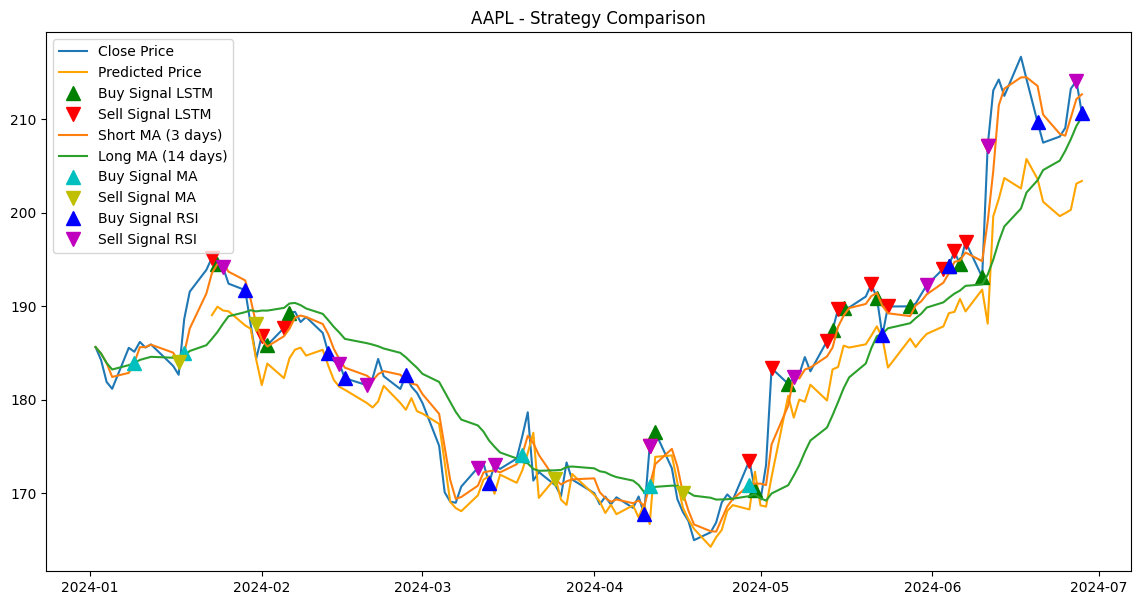

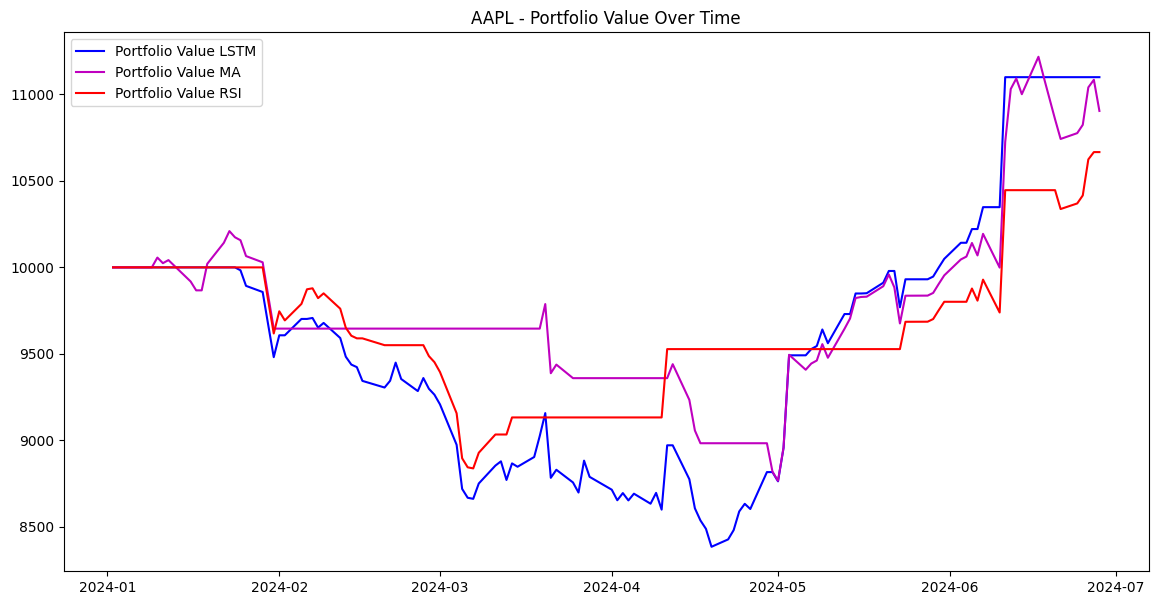

In [54]:

# Apply LSTM strategy
look_back = best_params['look_back']
buy_threshold = best_params['buy_threshold']
sell_threshold = best_params['sell_threshold']
data_test = make_lstm_predictions(model, scaler, data_test, look_back, buy_threshold, sell_threshold)

# Backtest LSTM strategy
return_LSTM_test = backtest_lstm(data_test)
print(f"LSTM Strategy Return: {return_LSTM_test:.2f}%")

# Plot the results
plt.figure(figsize=(14, 7))
plt.title(f'{symbol} - Strategy Comparison')
plt.plot(data_test['Close'], label='Close Price')
plt.plot(data_test['Predicted'], label='Predicted Price', color='orange')
plt.plot(data_test[data_test['Position_LSTM'] == 1.0].index, data_test['Close'][data_test['Position_LSTM'] == 1.0], '^', markersize=10, color='g', lw=0, label='Buy Signal LSTM')
plt.plot(data_test[data_test['Position_LSTM'] == -1.0].index, data_test['Close'][data_test['Position_LSTM'] == -1.0], 'v', markersize=10, color='r', lw=0, label='Sell Signal LSTM')

plt.plot(data_test['Short_MA'], label='Short MA (3 days)')
plt.plot(data_test['Long_MA'], label='Long MA (14 days)')
plt.plot(data_test[data_test['Position_MA'] == 1.0].index, data_test['Short_MA'][data_test['Position_MA'] == 1.0], '^', markersize=10, color='c', lw=0, label='Buy Signal MA')
plt.plot(data_test[data_test['Position_MA'] == -1.0].index, data_test['Short_MA'][data_test['Position_MA'] == -1.0], 'v', markersize=10, color='y', lw=0, label='Sell Signal MA')
plt.plot(data_test[data_test['Position_RSI'] == 1.0].index, data_test['Close'][data_test['Position_RSI'] == 1.0], '^', markersize=10, color='b', lw=0, label='Buy Signal RSI')
plt.plot(data_test[data_test['Position_RSI'] == -1.0].index, data_test['Close'][data_test['Position_RSI'] == -1.0], 'v', markersize=10, color='m', lw=0, label='Sell Signal RSI')
plt.legend()

# Plot portfolio value
plt.figure(figsize=(14, 7))
plt.plot(data_test['Portfolio_LSTM'], label='Portfolio Value LSTM', color='blue')
plt.plot(data_test.index, data_test['Portfolio_MA'], label='Portfolio Value MA', color='m')
plt.plot(data_test.index, data_test['Portfolio_RSI'], label='Portfolio Value RSI', color='red')
plt.title(f'{symbol} - Portfolio Value Over Time')
plt.legend()
plt.show()

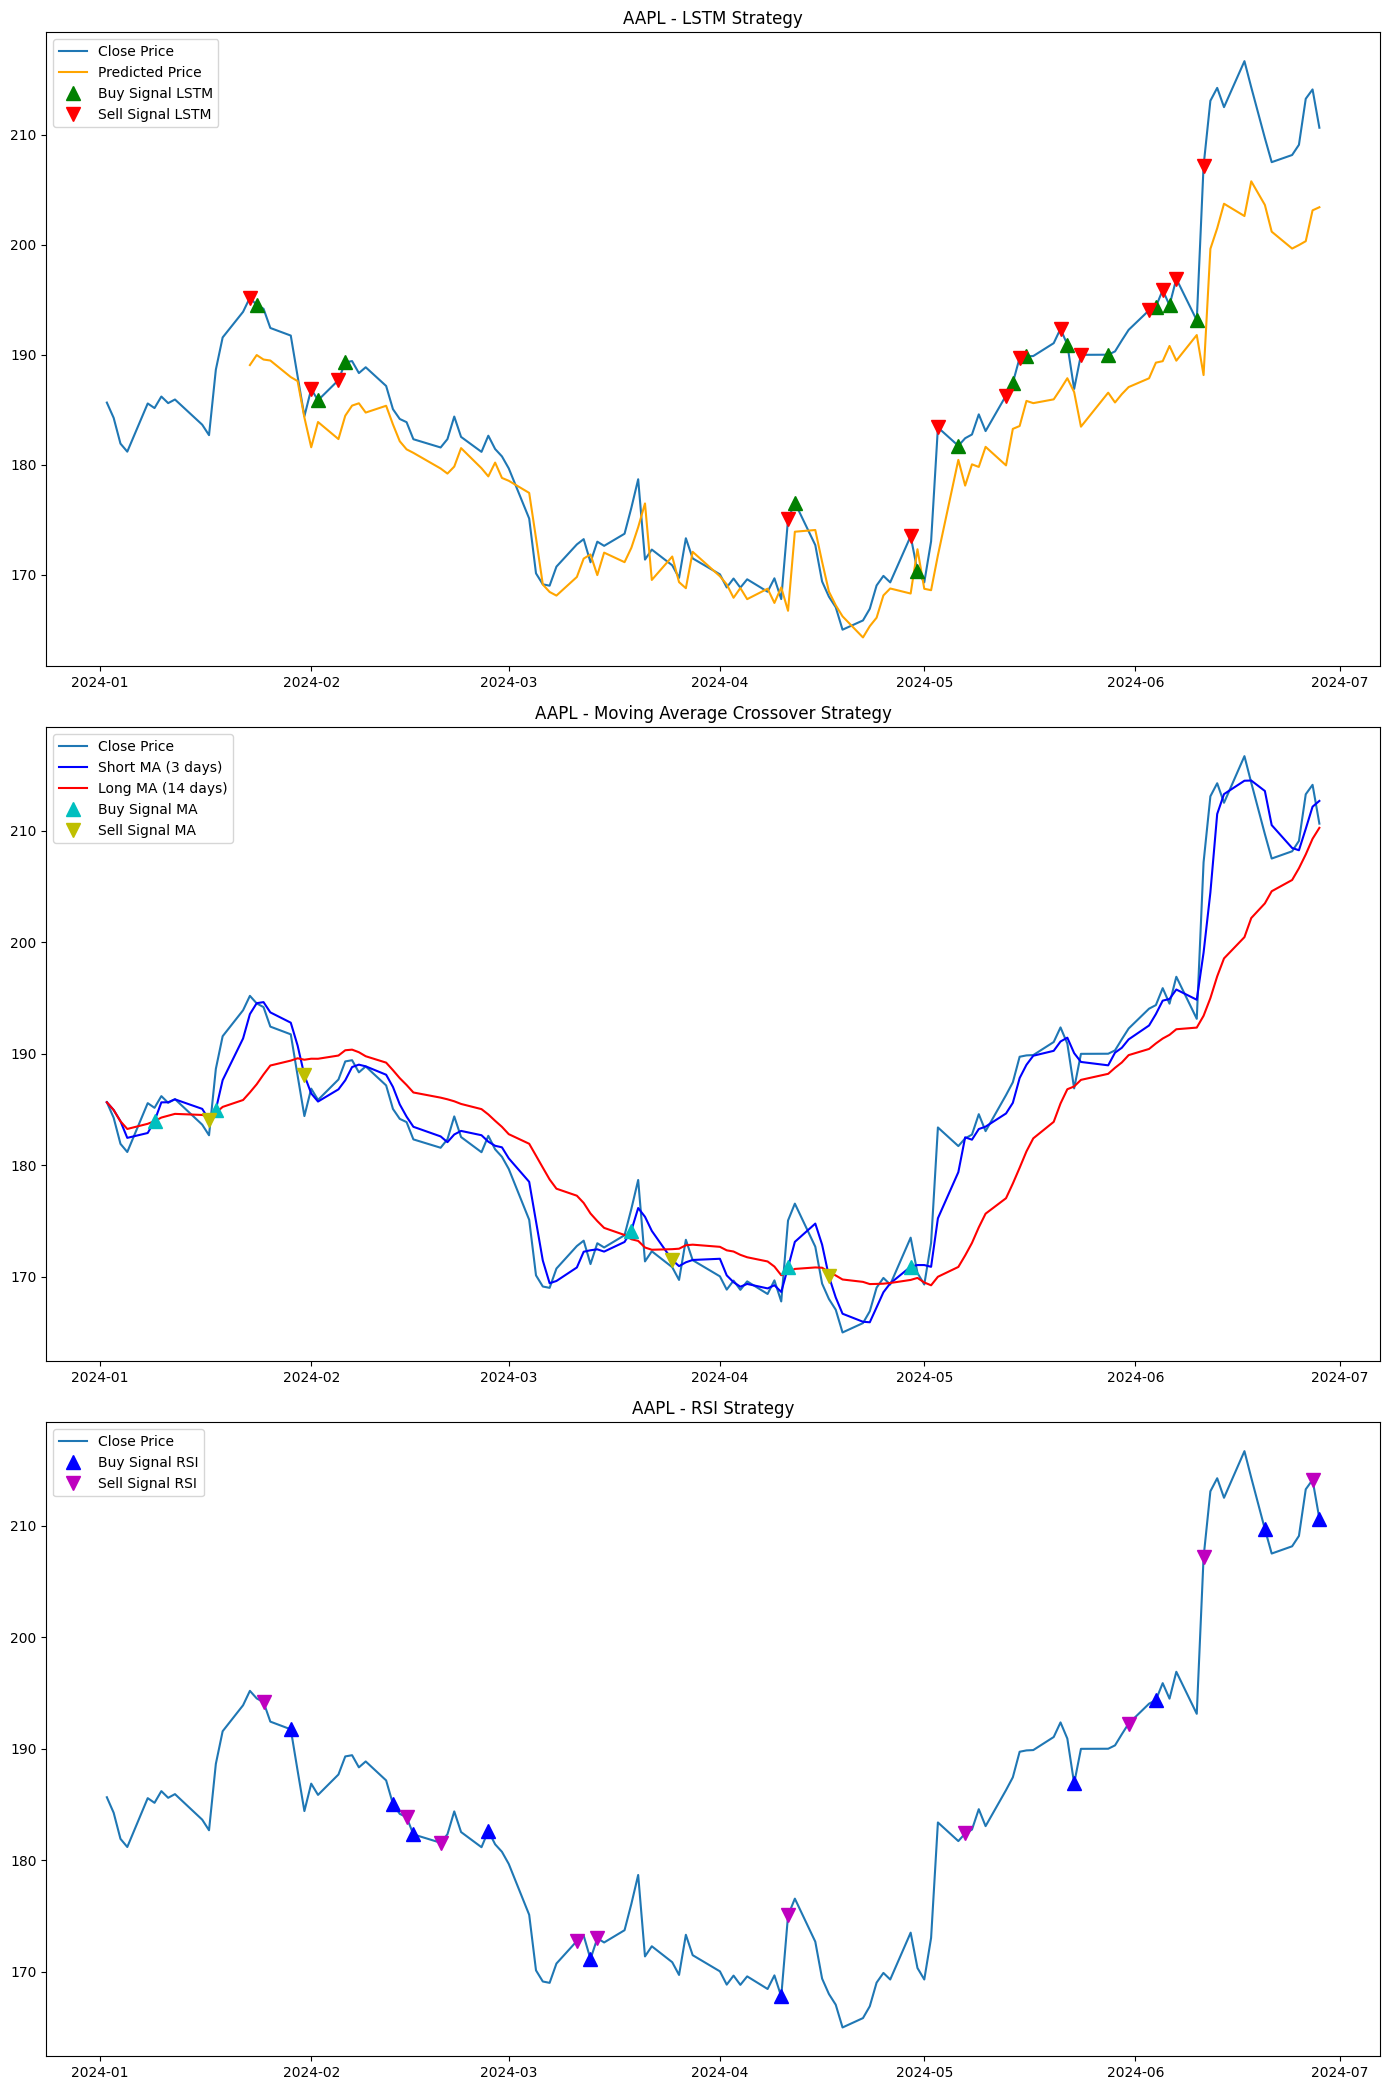

In [55]:
import matplotlib.pyplot as plt

# Create a figure with multiple subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 21))

# Plot for LSTM Strategy
axs[0].plot(data_test['Close'], label='Close Price')
axs[0].plot(data_test['Predicted'], label='Predicted Price', color='orange')
axs[0].plot(data_test[data_test['Position_LSTM'] == 1.0].index, data_test['Close'][data_test['Position_LSTM'] == 1.0], '^', markersize=10, color='g', lw=0, label='Buy Signal LSTM')
axs[0].plot(data_test[data_test['Position_LSTM'] == -1.0].index, data_test['Close'][data_test['Position_LSTM'] == -1.0], 'v', markersize=10, color='r', lw=0, label='Sell Signal LSTM')
axs[0].set_title(f'{symbol} - LSTM Strategy')
axs[0].legend()

# Plot for Moving Average Crossover Strategy
axs[1].plot(data_test['Close'], label='Close Price')
axs[1].plot(data_test['Short_MA'], label='Short MA (3 days)', color='blue')
axs[1].plot(data_test['Long_MA'], label='Long MA (14 days)', color='red')
axs[1].plot(data_test[data_test['Position_MA'] == 1.0].index, data_test['Short_MA'][data_test['Position_MA'] == 1.0], '^', markersize=10, color='c', lw=0, label='Buy Signal MA')
axs[1].plot(data_test[data_test['Position_MA'] == -1.0].index, data_test['Short_MA'][data_test['Position_MA'] == -1.0], 'v', markersize=10, color='y', lw=0, label='Sell Signal MA')
axs[1].set_title(f'{symbol} - Moving Average Crossover Strategy')
axs[1].legend()

# Plot for RSI Strategy
axs[2].plot(data_test['Close'], label='Close Price')
axs[2].plot(data_test[data_test['Position_RSI'] == 1.0].index, data_test['Close'][data_test['Position_RSI'] == 1.0], '^', markersize=10, color='b', lw=0, label='Buy Signal RSI')
axs[2].plot(data_test[data_test['Position_RSI'] == -1.0].index, data_test['Close'][data_test['Position_RSI'] == -1.0], 'v', markersize=10, color='m', lw=0, label='Sell Signal RSI')
axs[2].set_title(f'{symbol} - RSI Strategy')
axs[2].legend()

plt.tight_layout()
plt.show()
